# yFinance

This is a Python library that pulls financial data for the requested...name?

In [22]:
import yfinance as yf

# Define the ticker symbol
ticker_symbol = "AAPL"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period="5y")  # data for the last year
print("Historical Data:")
print(historical_data)

# Fetch basic financials
financials = ticker.financials
print("\nFinancials:")
print(financials)

# Fetch stock actions like dividends and splits
actions = ticker.actions
print("\nStock Actions:")
print(actions)

Historical Data:
                                 Open        High         Low       Close  \
Date                                                                        
2020-04-09 00:00:00-04:00   65.207883   65.540353   64.237167   65.035576   
2020-04-13 00:00:00-04:00   65.113207   66.421251   64.511361   66.312042   
2020-04-14 00:00:00-04:00   67.950134   69.952236   67.476907   69.661018   
2020-04-15 00:00:00-04:00   68.532539   69.486266   68.103000   69.025177   
2020-04-16 00:00:00-04:00   69.741103   69.940102   68.520428   69.573654   
...                               ...         ...         ...         ...   
2025-04-03 00:00:00-04:00  205.539993  207.490005  201.250000  203.190002   
2025-04-04 00:00:00-04:00  193.889999  199.880005  187.339996  188.380005   
2025-04-07 00:00:00-04:00  177.199997  194.149994  174.619995  181.460007   
2025-04-08 00:00:00-04:00  186.699997  190.339996  169.210007  172.419998   
2025-04-09 00:00:00-04:00  172.179001  181.070007  171.8899

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming historical_data is a pandas DataFrame
# Replace this with your actual data loading mechanism
historical_data = pd.read_csv('top10_sp100_companies.csv')

# Example data
data = {
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'feature2': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    'target': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}
historical_data = pd.DataFrame(data)

# Define features and target
X = historical_data.drop('target', axis=1)
y = historical_data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.8468


In [24]:
import pandas as pd

# Load your CSV
df = pd.read_csv("top10_sp100_companies.csv")

# Convert the date column properly
df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.date

# Pivot to get close prices with tickers as columns
price_df = df.pivot(index="Date", columns="Ticker", values="Close")
price_df = price_df.sort_index()

# Compute daily returns
returns_df = price_df.pct_change().dropna()

# Compute benchmark as equal-weighted average
returns_df["BENCHMARK"] = returns_df.mean(axis=1)

# Save as a .dat-style format for AMPL
with open("returns_data.dat", "w") as f:
    tickers = list(returns_df.columns.difference(["BENCHMARK"]))
    f.write(f"set S := {' '.join(tickers)};\n")
    f.write(f"set T := {' '.join(['t' + str(i) for i in range(len(returns_df))])};\n\n")
    
    f.write("param r :\n")
    f.write("       " + ' '.join(['t' + str(i) for i in range(len(returns_df))]) + " :=\n")
    
    for ticker in tickers:
        f.write(f"{ticker} " + ' '.join(f"{returns_df.iloc[i][ticker]:.6f}" for i in range(len(returns_df))) + "\n")
    f.write(";\n\n")
    
    f.write("param b :=\n")
    for i in range(len(returns_df)):
        f.write(f"t{i} {returns_df.iloc[i]['BENCHMARK']:.6f}\n")
    f.write(";\n")


In [25]:
from amplpy import AMPL
ampl = AMPL()

In [26]:
ampl.set_option("solver", "cbc")
ampl.eval('''

reset;
set S;                 # stocks
set T;                 # time periods

param q integer;       # number of stocks to select
param r {S,T};         # returns of stocks
param b {T};           # benchmark returns

var x {S} binary;      # stock inclusion
var w {S} >= 0;        # weight of stock

subject to cardinality:
    sum {i in S} x[i] = q;

subject to total_weight:
    sum {i in S} w[i] = 1;

subject to weight_limit {i in S}:
    w[i] <= x[i];

var p {T};             # portfolio returns at time t

subject to portfolio_def {t in T}:
    p[t] = sum {i in S} w[i] * r[i,t];

minimize tracking_error:
    sum {t in T} (p[t] - b[t])^2;
''')

In [27]:
# ampl.solve()

In [30]:
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"],
    license_uuid="18173b93-c75d-4d63-a2f4-38b78354b605")

ampl.set_option("solver", "cbc")

# Load model and data files
ampl.read("index_tracking.mod")
ampl.read_data("returns_data.dat")

# Set q (number of selected stocks)
ampl.param["q"] = 5  # change this as needed

# Solve the model
ampl.solve()

# Display selected stocks and their weights
selected_stocks = ampl.get_variable("x").to_dict()
weights = ampl.get_variable("w").to_dict()

print("Selected Stocks:")
for stock, chosen in selected_stocks.items():
    if chosen > 0.5:  # binary flag
        print(f"{stock} - weight: {weights[stock]:.4f}")


Licensed to AMPL Academic Community Edition License for <x23430133@student.ncirl.ie>.
cbc 2.10.10: 
------------ WARNINGS ------------
WARNING.  750 case(s) of "PLApprox". One of them:
  An expression of type 'PowConstExp' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
WARNING.  750 case(s) of "PLApproxDomain". One of them:
  Argument domain of a 'PowConstExp'
has been reduced to [-316.227766, 316.227766] for numerical reasons
(partially controlled by cvt:plapprox:domain.)
cbc 2.10.10: optimal solution; objective 0.2180860888
1.95133e+08 simplex iterations
195132690 barrier iterations
718440 branching nodes
 
------------ WARNINGS ------------
WARNING.  750 case(s) of "PLApprox". One of them:
  An expression of type 'PowConstExp' has been
piecewise-linearly approximated. Set cvt:plapprox:reltol
to control precision (currently 0.010000).
WARNING.  750 case(s) of "PLApproxDomain". One of them:
  Argument domain of a 'PowConstE

Portfolio Returns:
      p.val
t0        0
t1        0
t10       0
t100      0
t101      0
...     ...
t95       0
t96       0
t97       0
t98       0
t99       0

[750 rows x 1 columns]
Benchmark Returns:
             b
t0   -0.004903
t1    0.008382
t10  -0.000182
t100 -0.006463
t101  0.016361
...        ...
t95  -0.007806
t96  -0.007737
t97  -0.004646
t98   0.009299
t99  -0.014454

[750 rows x 1 columns]


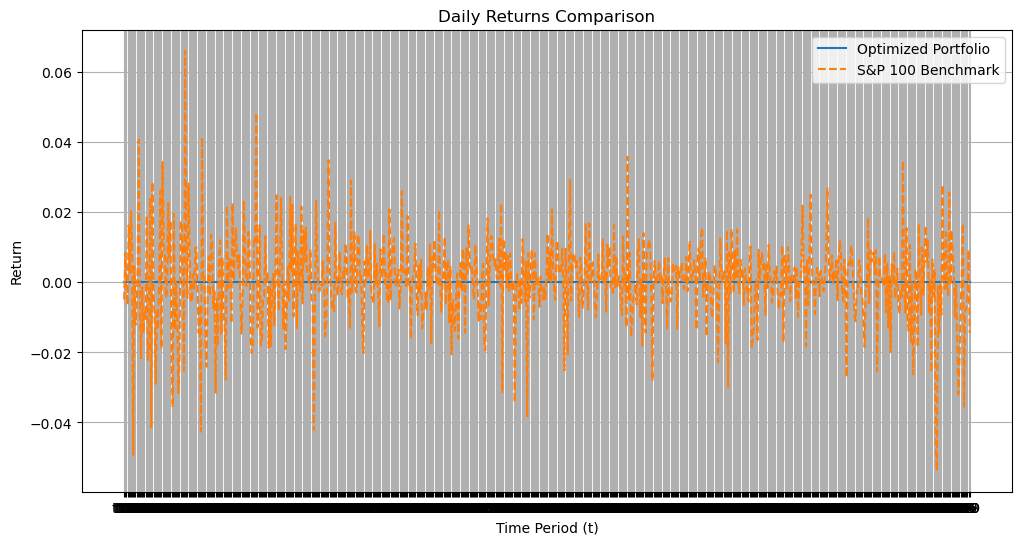

In [ ]:
# Extract portfolio and benchmark returns
p = ampl.get_variable("p").to_pandas()
print("Portfolio Returns:")
print(p)
b = ampl.get_parameter("b").to_pandas()
print("Benchmark Returns:")
print(b)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(p.index, p.values, label="Optimized Portfolio")
plt.plot(b.index, b.values, label="S&P 100 Benchmark", linestyle="--")
plt.title("Daily Returns Comparison")
plt.xlabel("Time Period (t)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import numpy as np
import pandas as pd

# Get portfolio returns and benchmark from AMPL
p_series = ampl.get_variable("p").to_pandas()
b_series = ampl.get_parameter("b").to_pandas()

# Ensure aligned indices (in case of weird ordering)
p_series = p_series.sort_index()
b_series = b_series.sort_index()

# Convert to NumPy arrays
p_returns = p_series.values
b_returns = b_series.values

# ✅ 1. Correlation
correlation = np.corrcoef(p_returns, b_returns)[0, 1]

# ✅ 2. Tracking Error (root mean square of differences)
tracking_error = np.sqrt(np.mean((p_returns - b_returns) ** 2))

# ✅ Print Results
print(f"📈 Correlation:     {correlation:.4f}")
print(f"📉 Tracking Error:  {tracking_error:.6f}")


📈 Correlation:     nan
📉 Tracking Error:  0.003467


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [43]:
results = []
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex"],
    license_uuid="18173b93-c75d-4d63-a2f4-38b78354b605")

ampl.set_option("solver", "cplex")

# Load model and data files
ampl.read("index_tracking.mod")
ampl.read_data("returns_data.dat")
for q_val in range(1, 13):  # try values from 3 to 10
    ampl.param["q"] = q_val
    ampl.solve()
    p_series = ampl.get_variable("p").to_pandas().sort_index()
    b_series = ampl.get_parameter("b").to_pandas().sort_index()

    p = p_series.values
    b = b_series.values
    corr = np.corrcoef(p, b)[0, 1]
    te = np.sqrt(np.mean((p - b)**2))
    results.append((q_val, corr, te))

df_results = pd.DataFrame(results, columns=["q", "Correlation", "TrackingError"])
print(df_results)

Licensed to AMPL Academic Community Edition License for <x23430133@student.ncirl.ie>.
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.07544379658
14 simplex iterations


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.03062159614
147 simplex iterations
60 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.02032648408
351 simplex iterations
149 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.01277919873
543 simplex iterations
216 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.007837820071
582 simplex iterations
226 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.004953233064
449 simplex iterations
172 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.002840425809
322 simplex iterations
105 branching nodes
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.001641715224
10 simplex iterations
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 0.000689908407
18 simplex iterations
CPLEX 22.1.1CPLEX 22.1.1: optimal solution; objective 6.465426805e-11
0 simplex iterations
	presolve: constraint Cardinality cannot hold:
		body >= 11

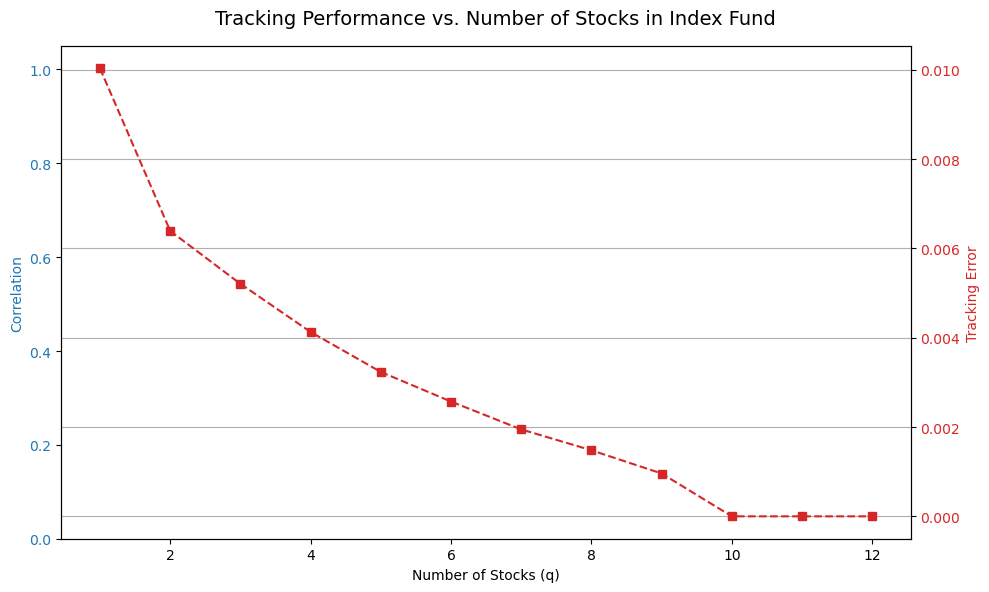

In [44]:
import matplotlib.pyplot as plt

# Plot correlation and tracking error vs. q
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Stocks (q)')
ax1.set_ylabel('Correlation', color=color)
ax1.plot(df_results["q"], df_results["Correlation"], marker='o', color=color, label="Correlation")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.05)

ax2 = ax1.twinx()  # Create a second y-axis for tracking error
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
ax2.plot(df_results["q"], df_results["TrackingError"], marker='s', linestyle='--', color=color, label="Tracking Error")
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Tracking Performance vs. Number of Stocks in Index Fund", fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()
